# Pointcloud semantic segmentation - MNIST demo

Small example how to train mini CNN network for point cloud semantic segmentation. 

To use GPU go to Runtime -> Change run type -> Hardware aceleration -> GPU

In [0]:
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, BatchNormalization
from tensorflow.python.keras.layers import Lambda;
from tensorflow.keras import optimizers
import random

Helper functions and color for prety plots. 

In [0]:
labels = {"0":{"code":"0","name":"0","color":"#c5d9f9",},"1":{"code":"1","name":"1","color":"#9842f4",},"2":{"code":"2","name":"2","color":"#ffbd0a",},"3":{"code":"3","name":"3","color":"#00ad1a",},"4":{"code":"4","name":"4","color":"#c40330",},"5":{"code":"5","name":"5","color":"#870521",},"6":{"code":"6","name":"6","color":"#f702de",},"7":{"code":"7","name":"7","color":"#ffbd0a",},"8":{"code":"8","name":"8","color":"#972ac9",},"9":{"code":"9","name":"9","color":"#3909f9",},"10":{"code":"10","name":"10","color":"#d8d8d8",},}


In [0]:
def transform_to_point_cloud(image, label, scale=28, onehot=False):
    points = []
    y_semantic = []
    for x, row in enumerate(image):
        for y, value in enumerate(row):
            points.append([x/scale, y/scale, value/8])
            if value != 0:
                if onehot:
                    vec = np.zeros(11)
                    vec[int(label)] = 1
                    y_semantic.append(vec)
                else:
                    y_semantic.append(label) 
            else:
                if onehot:
                    vec = np.zeros(11)
                    vec[10] = 1
                    y_semantic.append(vec)
                else:
                    y_semantic.append(10)#10 is artifical ground
    # TODO HAVE TO DO PROPER SHUFFFLE AND TAKE INTO ACCOUNT LABELS
    s = np.arange(np.shape(points)[0])
    np.random.shuffle(s)

    sigma = 0.002
    n, d = np.shape(points)
    points = np.random.randn(n, d) * sigma + points
    return np.array(points)[s], np.array(y_semantic)[s]



def transform_data(x, y, max_points=100, onehot=False):
    x_points = []
    y_semantic = []
    for i, image in enumerate(x):
        points, y_sem = transform_to_point_cloud(image, y[i], scale=28, onehot=onehot)
        if (np.shape(points)[0] < max_points):
            print('Houston we have a problem. Not enought points in data set!')
        x_points.append([points[:max_points, :]])
        y_semantic.append(y_sem[:max_points])


    return np.asarray(x_points, np.float32), np.asarray(y_semantic, np.float32)

def stupidConcat(a, b):
    c = []
    for i, v in enumerate(a):
        c.append([v[0], v[1], v[2], b[i]])
    return c

def convertToOneHot(y, number_of_classes):
    all_labels = []
    for data in y:
        oneHotEncoded = []
        for label in data:
            vec = np.zeros(number_of_classes)
            vec[int(label)] = 1
            oneHotEncoded.append(vec)
        all_labels.append(oneHotEncoded)
    return np.array(all_labels)

def plot_3d(points, max_points=1000, title=None, save=False, path=None, labels=None, label_vector=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    color = 'k'
    label = 'point'

    np.random.shuffle(points)
    plotpoints = points[:max_points, :]

    if labels is not None:
        for key, l in labels.items():
            group = []
            if label_vector:
                point_labels = label_vector
            else:
                point_labels = plotpoints[:, 3]
            group = plotpoints[point_labels == int(key)]
            color = l['color']
            label = l['name']
            if len(group) > 0:
                ax.scatter(group[:, 0], group[:, 1], group[:, 2], c=color, label=label)

    else:
        for point in plotpoints:
            code = 0
            if len(point) >= 4:
                color = 'k'
                label = str(int(point[3]))

            ax.scatter(point[0], point[1], point[2], c=color)

    if title:
        ax.set_title(title)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend(loc='upper left')
    plt.axis('equal')

    if save:
        if path is None:
            raise Exception('Path to location has to be provided')
        plt.savefig('{0}plt_{1}.png'.format(path, title))
    else:
        plt.show()

Load MNIST dataset

In [4]:
mnist = tf.keras.datasets.mnist
max_points = 784
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


Visulaze one image

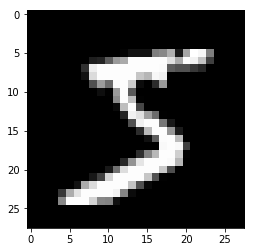

In [5]:
first_train_image = x_train[0]
first_train_image = np.array(first_train_image, dtype='float')
pixels = first_train_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

Transform images to point clouds. It may take few minutes.

In [0]:
x_train_points, y_semantic_train = transform_data(x_train, y_train, max_points=max_points, onehot=True)
x_test_points, y_semantic_test = transform_data(x_test, y_test, max_points=max_points, onehot=True)

Visualzation of first image to point cloud.

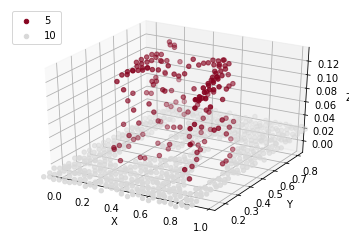

In [7]:
i = 0
points, label_vector = transform_to_point_cloud(x_train[i], y_train[i])
points[:100,:]
c = stupidConcat(points, label_vector)
plot_3d(np.array(c), labels=labels)

 ## Model

In [8]:
def repeat_elements(d, name='repeat_elements'):
    return  tf.keras.backend.repeat_elements(d, max_points, 2)

def squeez(e, name='squeez'):
    return tf.keras.backend.squeeze(e, axis=1)

def reshape(p, name='reshape'):
    shape = tf.keras.backend.shape(p)
    return tf.keras.backend.reshape(predictions, [shape[0] , 10, max_points])

def shuffel(p, name='shuffel'):
    shape = tf.keras.backend.shape(p)
    return tf.keras.backend.reshape(predictions, [shape[0] , 10, max_points])

inputs = tf.keras.Input(shape=(1, max_points, 3))

x = Dense(64, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
point_features = Dense(64, activation='relu')(x)
x = BatchNormalization()(point_features)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, input_shape=(1, 1), activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
global_features = MaxPooling2D(pool_size=(1,max_points), padding='VALID')(x)
global_features = Lambda(repeat_elements)(global_features);

merged = Concatenate(3)([point_features, global_features])

x = Dense(256, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, input_shape=(1, 1), activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, input_shape=(1, 1), activation='relu')(x)
x = BatchNormalization()(x)

x = Dropout(0.3)(x)
x = Dense(11, activation=tf.nn.softmax)(x)

x = Lambda(squeez)(x);

model = tf.keras.Model(inputs=inputs, outputs=x)

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=[ 'accuracy'])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
sample_count = np.shape(x_train_points)[0]
batch_size = 32

history = model.fit(x_train_points, y_semantic_train, epochs=30, batch_size=64, validation_split=0.1)
model.evaluate(x_test_points, y_semantic_test)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - 142s 3ms/sample - loss: 3.1642 - acc: 0.0983 - val_loss: 6.3591 - val_acc: 0.0386
Epoch 2/40
54000/54000 [==============================] - 137s 3ms/sample - loss: 2.7388 - acc: 0.1906 - val_loss: 6.5731 - val_acc: 0.0651
Epoch 3/40
54000/54000 [==============================] - 136s 3ms/sample - loss: 2.1204 - acc: 0.4115 - val_loss: 7.1539 - val_acc: 0.0225
Epoch 4/40
54000/54000 [==============================] - 136s 3ms/sample - loss: 1.4056 - acc: 0.6532 - val_loss: 2.9283 - val_acc: 0.0692
Epoch 5/40
54000/54000 [==============================] - 137s 3ms/sample - loss: 1.0308 - acc: 0.7666 - val_loss: 1.2752 - val_acc: 0.6298
Epoch 6/40
54000/54000 [==============================] - 137s 3ms/sample - loss: 0.8488 - acc: 0.8050 - val_loss: 0.9514 - val_acc: 0.7813
Epoch 7/40
54000/

In [0]:
history_dict = history.history
history_dict.keys()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
show = {
    '0': 3,
    '1': 5,
    '2': 1,
    '3': 18,
    '4': 19,
    '5': 8,
    '6': 11,
    '7': 0,
    '8': 61,
    '9': 1000,
}
index = 61

# 1000 je kul
ynew = model.predict(x_test_points)

def create_label_vector(ynew):
    la = []
    for y in ynew:
        la.append(np.argmax(y, -1))
    return la

for name, index in show.items():
    c = stupidConcat(x_test_points[index][0], create_label_vector(ynew[index]))
    plot_3d(np.array(c), labels=labels, title='True value: {0}'.format(y_test[index]))